In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess_aqi_data(input_csv, output_csv):
    df = pd.read_csv(input_csv)
    print("Columns in dataset:", df.columns.tolist())
    df.columns = df.columns.str.strip().str.lower()
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].apply(lambda col: col.fillna(col.median()))

    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if not df[col].isnull().all():  # Avoid issues if the whole column is NaN
            df[col] = df[col].fillna(df[col].mode()[0])


    df.drop_duplicates(inplace=True)


    if 'city' in df.columns:
        df = pd.get_dummies(df, columns=['city'], drop_first=True)
    else:
        print("Warning: 'city' column is missing. Proceeding without it.")


    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
        df.dropna(subset=['date'], inplace=True)  # Remove rows where date conversion failed
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
    else:
        print("Error: 'date' column is missing. Check the dataset.")


    if 'nox' not in df.columns and 'no' in df.columns and 'no2' in df.columns:
        df['nox'] = df['no'] + df['no2']

    outlier_cols = ['pm10', 'pm2_5', 'no', 'no2', 'nox', 'o3', 'co', 'aqi']
    outlier_cols = [col for col in outlier_cols if col in df.columns]


    if outlier_cols:
        Q1 = df[outlier_cols].quantile(0.25)
        Q3 = df[outlier_cols].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[outlier_cols] < (Q1 - 1.5 * IQR)) | (df[outlier_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


    all_numeric_cols = df.select_dtypes(include=['number']).columns
    scaler = MinMaxScaler()
    df[all_numeric_cols] = scaler.fit_transform(df[all_numeric_cols])


    df.to_csv(output_csv, index=False)
    print(f"Preprocessed data saved to {output_csv}")


input_csv = 'final_air_pollution_data.csv'
output_csv = 'aqi_dataset.csv'
preprocess_aqi_data(input_csv, output_csv)


Columns in dataset: ['city', 'date', 'aqi', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
Preprocessed data saved to aqi_dataset.csv


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load dataset
file_path = "aqi_dataset.csv"  # Ensure this file is in the correct directory
df = pd.read_csv(file_path)

# Define features (pollutants) and target variable (AQI)
target_column = "aqi"  # Ensure this column name matches exactly
X = df[['pm10', 'pm2_5', 'no', 'no2', 'nox', 'o3', 'co']]  # Select relevant features
y = df[target_column]  # Target variable (AQI)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Extract feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Print feature importance scores
print("Feature Importance Scores:")
for feature, importance in feature_importance.items():
    print(f"{feature}: {importance:.6f}")


Feature Importance Scores:
pm2_5: 0.837502
pm10: 0.072983
co: 0.026634
o3: 0.025457
no2: 0.017080
nox: 0.016747
no: 0.003597


In [ ]:
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load dataset
file_path = "aqi_dataset.csv"  # Ensure this file is in the correct directory
df = pd.read_csv(file_path)

# Define features (pollutants) and target variable (AQI)
target_column = "aqi"
X = df[['pm10', 'pm2_5', 'no', 'no2', 'nox', 'o3', 'co']]  # Select relevant features
y = df[target_column]  # Target variable (AQI)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Initialize SHAP explainer
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_test)

# Print SHAP Feature Importance Scores
print("SHAP Feature Importance Scores:")
shap_importance = pd.DataFrame({"Feature": X.columns, "SHAP Importance": abs(shap_values.values).mean(axis=0)})
shap_importance = shap_importance.sort_values(by="SHAP Importance", ascending=False)

# Display feature importance scores in a clean format
for feature, importance in zip(shap_importance["Feature"], shap_importance["SHAP Importance"]):
    print(f"{feature}: {importance:.6f}")


SHAP Feature Importance Scores:
pm2_5: 0.122131
pm10: 0.040616
co: 0.007184
o3: 0.003555
no2: 0.003433
nox: 0.003431
no: 0.001166


<ipython-input-1-51f9f0298e46>:9: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'])


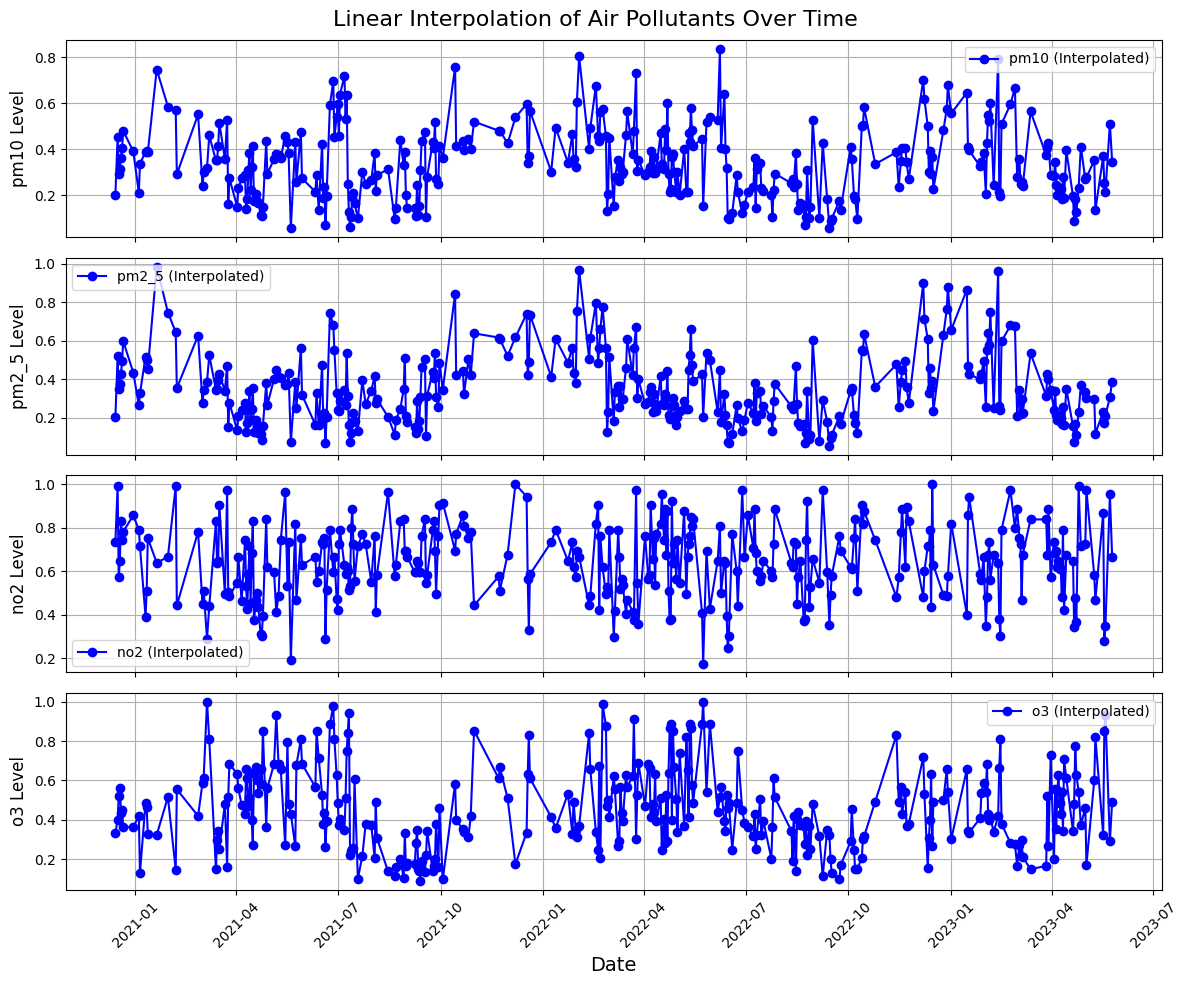

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load preprocessed AQI dataset
df = pd.read_csv("aqi_dataset.csv")

# Convert date to datetime format
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])

# Select numerical columns for interpolation
interpolation_cols = ['pm10', 'pm2_5', 'no2', 'o3']
existing_cols = [col for col in interpolation_cols if col in df.columns]  # Ensure columns exist

# Apply linear interpolation
df[existing_cols] = df[existing_cols].interpolate(method='linear')

# Create a subplot for each pollutant
fig, axes = plt.subplots(len(existing_cols), 1, figsize=(12,10), sharex=True)

# Plot each pollutant separately
for i, col in enumerate(existing_cols):
    axes[i].plot(df['date'], df[col], marker='o', linestyle='-', label=f"{col} (Interpolated)", color='b')
    axes[i].set_ylabel(f"{col} Level", fontsize=12)
    axes[i].legend()
    axes[i].grid(True)

# Set common labels
plt.xlabel("Date", fontsize=14)
plt.suptitle("Linear Interpolation of Air Pollutants Over Time", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


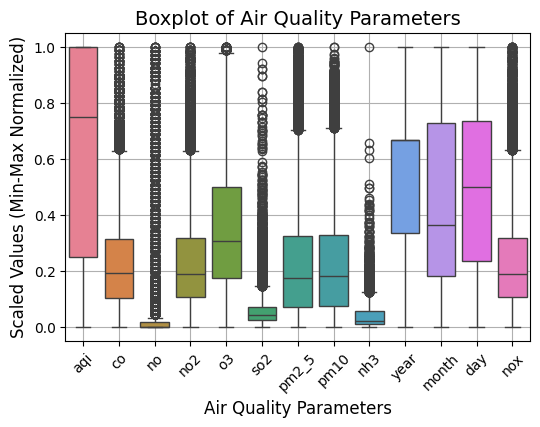

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed AQI dataset
df = pd.read_csv("aqi_dataset.csv")

# Select only numerical columns for boxplot
numeric_cols = df.select_dtypes(include=['number']).columns

# Set figure size
plt.figure(figsize=(9,8))

# Create boxplot for all numeric columns
sns.boxplot(data=df[numeric_cols])
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.title("Boxplot of Air Quality Parameters", fontsize=15)
plt.xlabel("Air Quality Parameters", fontsize=15)
plt.ylabel("Scaled Values (Min-Max Normalized)", fontsize=12)
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import zscore
df = pd.read_csv("aqi_dataset.csv")

if 'date_column' in df.columns:
    df['date_column'] = pd.to_datetime(df['date'])
    df['year'] = df['date_column'].dt.year
    df['month'] = df['date_column'].dt.month
    df['day'] = df['date_column'].dt.day#
    df.drop(columns=['date_column'], inplace=True)
df = df[(np.abs(zscore(df.select_dtypes(include=['number']))) < 3).all(axis=1)]
X = df.drop(columns=['aqi'])
y = df['aqi']
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()
poly = PolynomialFeatures(degree=2, include_bias=False)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', poly),
    ('model', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
print(f" Linear Regression - R² Value: {r2:.4f}")
print(f"  Linear Regression - RMSE Value: {rmse:.4f}")
print(f"  Linear Regression - MSE Value: {mse:.4f}")

 Linear Regression - R² Value: 0.7199
  Linear Regression - RMSE Value: 0.0916
  Linear Regression - MSE Value: 0.0084


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import zscore
df = pd.read_csv("aqi_dataset.csv")
if 'date_column' in df.columns:
    df['date_column'] = pd.to_datetime(df['date'])
    df['year'] = df['date_column'].dt.year
    df['month'] = df['date_column'].dt.month
    df['day'] = df['date_column'].dt.day
    df.drop(columns=['date_column'], inplace=True)
df = df[(np.abs(zscore(df.select_dtypes(include=['number']))) < 3).all(axis=1)]
X = df.drop(columns=['aqi'])
y = df['aqi']
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()
poly = PolynomialFeatures(degree=2, include_bias=False)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', poly),
    ('model', LinearRegression())
])
lr_pipeline.fit(X_train, y_train)
cv_mse_scores = cross_val_score(lr_pipeline, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_mse_scores = -cv_mse_scores
cv_rmse_scores = np.sqrt(cv_mse_scores)
y_pred = lr_pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
print(f"  Linear Regression - R² Value: {r2:.4f}")
print(f" Linear Regression - RMSE Value: {rmse:.4f}")
print(f" Linear Regression - MSE Value: {mse:.4f}")
print(f" Cross-Validation (10-Fold) - Mean MSE: {np.mean(cv_mse_scores):.4f}")
print(f" Cross-Validation (10-Fold) - Mean RMSE: {np.mean(cv_rmse_scores):.4f}")


  Linear Regression - R² Value: 0.7199
 Linear Regression - RMSE Value: 0.0916
 Linear Regression - MSE Value: 0.0084
 Cross-Validation (10-Fold) - Mean MSE: 0.0058
 Cross-Validation (10-Fold) - Mean RMSE: 0.0754


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

df = pd.read_csv("aqi_dataset.csv")
df = df.drop(columns=['date'])

X = df.drop(columns=['aqi'])
y = df['aqi']

categorical_features = ['city']
numerical_features = [col for col in X.columns if col not in categorical_features]

selector = SelectKBest(score_func=mutual_info_regression, k=min(12, len(numerical_features)))
X_selected = selector.fit_transform(df[numerical_features], y)
selected_feature_indices = selector.get_support(indices=True)
selected_numerical_cols = [numerical_features[i] for i in selected_feature_indices]

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('scaler', StandardScaler()),
        ('power', PowerTransformer(method='yeo-johnson')),
        ('poly', PolynomialFeatures(degree=2, include_bias=False))
    ]), selected_numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_train, X_test, y_train, y_test = train_test_split(X[selected_numerical_cols + categorical_features], y, test_size=0.2, random_state=42)

ridge_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
accuracy = max(0, min(1, r2)) * 100

print(f" Ridge Regression - R² Score: {r2:.4f}")
print(f" Ridge Regression - Mean Squared Error (MSE): {mse:.4f}")
print(f" Ridge Regression - Root Mean Squared Error (RMSE): {rmse:.4f}")


 Ridge Regression - R² Score: 0.8748
 Ridge Regression - Mean Squared Error (MSE): 0.0071
 Ridge Regression - Root Mean Squared Error (RMSE): 0.0841


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import r2_score, make_scorer, mean_squared_error

df = pd.read_csv("aqi_dataset.csv")
df = df.drop(columns=['date'])

X = df.drop(columns=['aqi'])
y = df['aqi']

categorical_features = ['city']
numerical_features = [col for col in X.columns if col not in categorical_features]

selector = SelectKBest(score_func=mutual_info_regression, k=min(12, len(numerical_features)))
X_selected = selector.fit_transform(df[numerical_features], y)
selected_feature_indices = selector.get_support(indices=True)
selected_numerical_cols = [numerical_features[i] for i in selected_feature_indices]

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('scaler', StandardScaler()),
        ('power', PowerTransformer(method='yeo-johnson')),
        ('poly', PolynomialFeatures(degree=2, include_bias=False))
    ]), selected_numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

ridge_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

kf = KFold(n_splits=10, shuffle=True, random_state=42)

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

r2_scores = cross_val_score(ridge_model, X[selected_numerical_cols + categorical_features], y, cv=kf, scoring='r2')
mse_scores = cross_val_score(ridge_model, X[selected_numerical_cols + categorical_features], y, cv=kf, scoring=mse_scorer)
rmse_scores = cross_val_score(ridge_model, X[selected_numerical_cols + categorical_features], y, cv=kf, scoring=rmse_scorer)

avg_r2 = np.mean(r2_scores)
avg_mse = -np.mean(mse_scores)
avg_rmse = -np.mean(rmse_scores)

print(f" Ridge Regression - Average R² Score (10-Fold CV): {avg_r2:.4f}")
print(f" Ridge Regression - Average Mean Squared Error (MSE): {avg_mse:.4f}")
print(f" Ridge Regression - Average Root Mean Squared Error (RMSE): {avg_rmse:.4f}")


 Ridge Regression - Average R² Score (10-Fold CV): 0.8079
 Ridge Regression - Average Mean Squared Error (MSE): 0.0064
 Ridge Regression - Average Root Mean Squared Error (RMSE): 0.0795


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

df = pd.read_csv("aqi_dataset.csv")
df = df.drop(columns=['date'])

X = df.drop(columns=['aqi'])
y = df['aqi']

categorical_features = ['city']
numerical_features = [col for col in X.columns if col not in categorical_features]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42))
])

gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
accuracy = max(0, min(1, r2)) * 100

print(f"Gradient Boosting Regression - R² Score: {r2:.4f}")
print(f"Gradient Boosting Regression - Mean Squared Error (MSE): {mse:.4f}")
print(f"Gradient Boosting Regression - Root Mean Squared Error (RMSE): {rmse:.4f}")


Gradient Boosting Regression - R² Score: 0.9505
Gradient Boosting Regression - Mean Squared Error (MSE): 0.0028
Gradient Boosting Regression - Root Mean Squared Error (RMSE): 0.0529


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, make_scorer, mean_squared_error

df = pd.read_csv("aqi_dataset.csv")
df = df.drop(columns=['date'])

X = df.drop(columns=['aqi'])
y = df['aqi']

categorical_features = ['city']
numerical_features = [col for col in X.columns if col not in categorical_features]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

gb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=200, learning_rate=0.05,
                                            max_depth=5, random_state=42))
])

kf = KFold(n_splits=10, shuffle=True, random_state=42)

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

r2_scores = cross_val_score(gb_model, X, y, cv=kf, scoring='r2')
mse_scores = cross_val_score(gb_model, X, y, cv=kf, scoring=mse_scorer)
rmse_scores = cross_val_score(gb_model, X, y, cv=kf, scoring=rmse_scorer)

avg_r2 = np.mean(r2_scores)
avg_mse = -np.mean(mse_scores)
avg_rmse = -np.mean(rmse_scores)

print(f"Gradient Boosting Regression - Average R² Score (10-Fold CV): {avg_r2:.4f}")
print(f"Gradient Boosting Regression - Average Mean Squared Error (MSE): {avg_mse:.4f}")
print(f"Gradient Boosting Regression - Average Root Mean Squared Error (RMSE): {avg_rmse:.4f}")


Gradient Boosting Regression - Average R² Score (10-Fold CV): 0.9667
Gradient Boosting Regression - Average Mean Squared Error (MSE): 0.0014
Gradient Boosting Regression - Average Root Mean Squared Error (RMSE): 0.0277


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def load_data(csv_file):
    data = pd.read_csv(csv_file)
    return data

def preprocess_data(data):
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    X = pd.get_dummies(X, drop_first=True)

    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    return X, y

def train_decision_tree(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    model = DecisionTreeRegressor(max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    return r2, mse, rmse

def main():
    csv_file = input("Enter CSV file name: ")
    data = load_data(csv_file)
    X, y = preprocess_data(data)
    r2, mse, rmse = train_decision_tree(X, y)

    print(f'R² Score: {r2:.4f}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

if __name__ == '__main__':
    main()


Enter CSV file name: aqi_dataset.csv
R² Score: 0.9709
Mean Squared Error (MSE): 0.0018
Root Mean Squared Error (RMSE): 0.0429


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def load_data(csv_file):
    data = pd.read_csv(csv_file)
    return data

def preprocess_data(data):
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    X = pd.get_dummies(X, drop_first=True)

    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    return X, y

def train_decision_tree_cv(X, y):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    r2_scores = []
    mse_scores = []
    rmse_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = DecisionTreeRegressor(max_depth=20, min_samples_split=2,
                                      min_samples_leaf=1, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        r2_scores.append(r2_score(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    avg_r2 = np.mean(r2_scores)
    avg_mse = np.mean(mse_scores)
    avg_rmse = np.mean(rmse_scores)

    return avg_r2, avg_mse, avg_rmse

def main():
    csv_file = input("Enter CSV file name: ")
    data = load_data(csv_file)
    X, y = preprocess_data(data)
    avg_r2, avg_mse, avg_rmse = train_decision_tree_cv(X, y)

    print(f'Average R² Score (10-Fold CV): {avg_r2:.4f}')
    print(f'Average Mean Squared Error (MSE): {avg_mse:.4f}')
    print(f'Average Root Mean Squared Error (RMSE): {avg_rmse:.4f}')

if __name__ == '__main__':
    main()


Enter CSV file name: aqi_dataset.csv
Average R² Score (10-Fold CV): 0.9678
Average Mean Squared Error (MSE): 0.0013
Average Root Mean Squared Error (RMSE): 0.0253


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def load_data(csv_file):
    data = pd.read_csv(csv_file)
    return data

def preprocess_data(data):
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    X = pd.get_dummies(X, drop_first=True)

    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    return X, y

def train_random_forest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    model = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    return r2, mse, rmse

def main():
    csv_file = input("Enter CSV file name: ")
    data = load_data(csv_file)
    X, y = preprocess_data(data)
    r2, mse, rmse = train_random_forest(X, y)

    print(f'R² Score: {r2:.4f}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

if __name__ == '__main__':
    main()


Enter CSV file name: aqi_dataset.csv
R² Score: 0.9836
Mean Squared Error (MSE): 0.0010
Root Mean Squared Error (RMSE): 0.0322


In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def load_data(csv_file):
    data = pd.read_csv(csv_file)
    return data

def preprocess_data(data):
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    X = pd.get_dummies(X, drop_first=True)

    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    return X, y

def train_random_forest_cv(X, y):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    r2_scores = []
    mse_scores = []
    rmse_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=2,
                                      min_samples_leaf=1, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        r2_scores.append(r2_score(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    avg_r2 = np.mean(r2_scores)
    avg_mse = np.mean(mse_scores)
    avg_rmse = np.mean(rmse_scores)

    return avg_r2, avg_mse, avg_rmse

def main():
    csv_file = input("Enter CSV file name: ")
    data = load_data(csv_file)
    X, y = preprocess_data(data)
    avg_r2, avg_mse, avg_rmse = train_random_forest_cv(X, y)

    print(f'Average R² Score (10-Fold CV): {avg_r2:.4f}')
    print(f'Average Mean Squared Error (MSE): {avg_mse:.4f}')
    print(f'Average Root Mean Squared Error (RMSE): {avg_rmse:.4f}')

if __name__ == '__main__':
    main()


Enter CSV file name: aqi_dataset.csv
Average R² Score (10-Fold CV): 0.9698
Average Mean Squared Error (MSE): 0.0011
Average Root Mean Squared Error (RMSE): 0.0305


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

def load_data(csv_file):
    data = pd.read_csv(csv_file)
    return data

def preprocess_data(data):
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    X = pd.get_dummies(X, drop_first=True)

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X = pd.DataFrame(scaler_X.fit_transform(X), columns=X.columns)
    y = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

    selector = SelectKBest(score_func=f_regression, k=min(15, X.shape[1]))
    X = selector.fit_transform(X, y)

    return X, y, scaler_y

def train_svr(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.03, random_state=42)

    param_grid = {'C': [10, 50, 100, 200], 'epsilon': [0.001, 0.0001, 0.00001], 'kernel': ['rbf', 'poly', 'sigmoid']}
    grid_search = GridSearchCV(SVR(), param_grid, cv=10, scoring='r2')
    grid_search.fit(X_train, y_train)

    model = grid_search.best_estimator_
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)

    return r2, rmse, mse

def main():
    csv_file = input("Enter CSV file name: ")
    data = load_data(csv_file)
    X, y, scaler_y = preprocess_data(data)
    r2, rmse, mse = train_svr(X, y)

    print(f'R² Score: {r2:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MSE: {mse:.4f}')

if __name__ == '__main__':
    main()


Enter CSV file name: aqi_dataset.csv
R² Score: 0.9340
RMSE: 0.3382
MSE: 0.1144


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

def load_data(csv_file):
    data = pd.read_csv(csv_file)
    return data

def preprocess_data(data):
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    X = pd.get_dummies(X, drop_first=True)

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X = pd.DataFrame(scaler_X.fit_transform(X), columns=X.columns)
    y = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

    selector = SelectKBest(score_func=f_regression, k=min(15, X.shape[1]))
    X = selector.fit_transform(X, y)

    return X, y, scaler_y

def train_svr(X, y):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    param_grid = {'C': [10, 50, 100, 200], 'epsilon': [0.001, 0.0001, 0.00001], 'kernel': ['rbf', 'poly', 'sigmoid']}
    grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='r2')
    grid_search.fit(X, y)

    model = grid_search.best_estimator_

    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=kf, scoring=make_scorer(mean_squared_error, greater_is_better=False)))
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring=make_scorer(mean_squared_error, greater_is_better=False))

    return np.mean(r2_scores), np.mean(rmse_scores), np.mean(mse_scores)

def main():
    csv_file = input("Enter CSV file name: ")
    data = load_data(csv_file)
    X, y, scaler_y = preprocess_data(data)
    r2, rmse, mse = train_svr(X, y)

    print(f"Average R² Score (10-fold CV): {r2:.4f}")
    print(f"Average RMSE (10-fold CV): {rmse:.4f}")
    print(f"Average MSE (10-fold CV): {mse:.4f}")

if __name__ == '__main__':
    main()


Enter CSV file name: aqi_dataset.csv
Average R² Score (10-fold CV): 0.8185
Average RMSE (10-fold CV): 0.4038
Average MSE (10-fold CV): 0.1667


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

def load_data(csv_file):
    data = pd.read_csv(csv_file)
    return data

def preprocess_data(data):
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    X = pd.get_dummies(X, drop_first=True)

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X = pd.DataFrame(scaler_X.fit_transform(X), columns=X.columns)
    y = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

    selector = SelectKBest(score_func=f_regression, k=min(15, X.shape[1]))
    X = selector.fit_transform(X, y)

    return X, y, scaler_y

def train_xgboost(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.03, random_state=42)

    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
    grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=10, scoring='r2')
    grid_search.fit(X_train, y_train)

    model = grid_search.best_estimator_
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)

    return r2, rmse, mse

def main():
    csv_file = input("Enter CSV file name: ")
    data = load_data(csv_file)
    X, y, scaler_y = preprocess_data(data)
    r2, rmse, mse = train_xgboost(X, y)

    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")

if __name__ == '__main__':
    main()


Enter CSV file name: aqi_dataset.csv
R² Score: 0.9999
RMSE: 0.0152
MSE: 0.0002


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

def load_data(csv_file):
    data = pd.read_csv(csv_file)
    return data

def preprocess_data(data):
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    X = pd.get_dummies(X, drop_first=True)

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X = pd.DataFrame(scaler_X.fit_transform(X), columns=X.columns)
    y = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

    selector = SelectKBest(score_func=f_regression, k=min(15, X.shape[1]))
    X = selector.fit_transform(X, y)

    return X, y

def train_xgboost(X, y):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
    grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=10, scoring='r2')
    grid_search.fit(X, y)

    model = grid_search.best_estimator_

    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    mse_scores = cross_val_score(model, X, y, cv=kf, scoring=make_scorer(mean_squared_error))
    rmse_scores = np.sqrt(mse_scores)

    return r2_scores.mean(), rmse_scores.mean(), mse_scores.mean()

def main():
    csv_file = input("Enter CSV file name: ")
    data = load_data(csv_file)
    X, y = preprocess_data(data)
    r2, rmse, mse = train_xgboost(X, y)

    print(f"Average R² Score (10-fold CV): {r2:.4f}")
    print(f"Average RMSE (10-fold CV): {rmse:.4f}")
    print(f"Average MSE (10-fold CV): {mse:.4f}")

if __name__ == '__main__':
    main()


Enter CSV file name: aqi_dataset.csv
Average R² Score (10-fold CV): 0.9801
Average RMSE (10-fold CV): 0.1242
Average MSE (10-fold CV): 0.0220


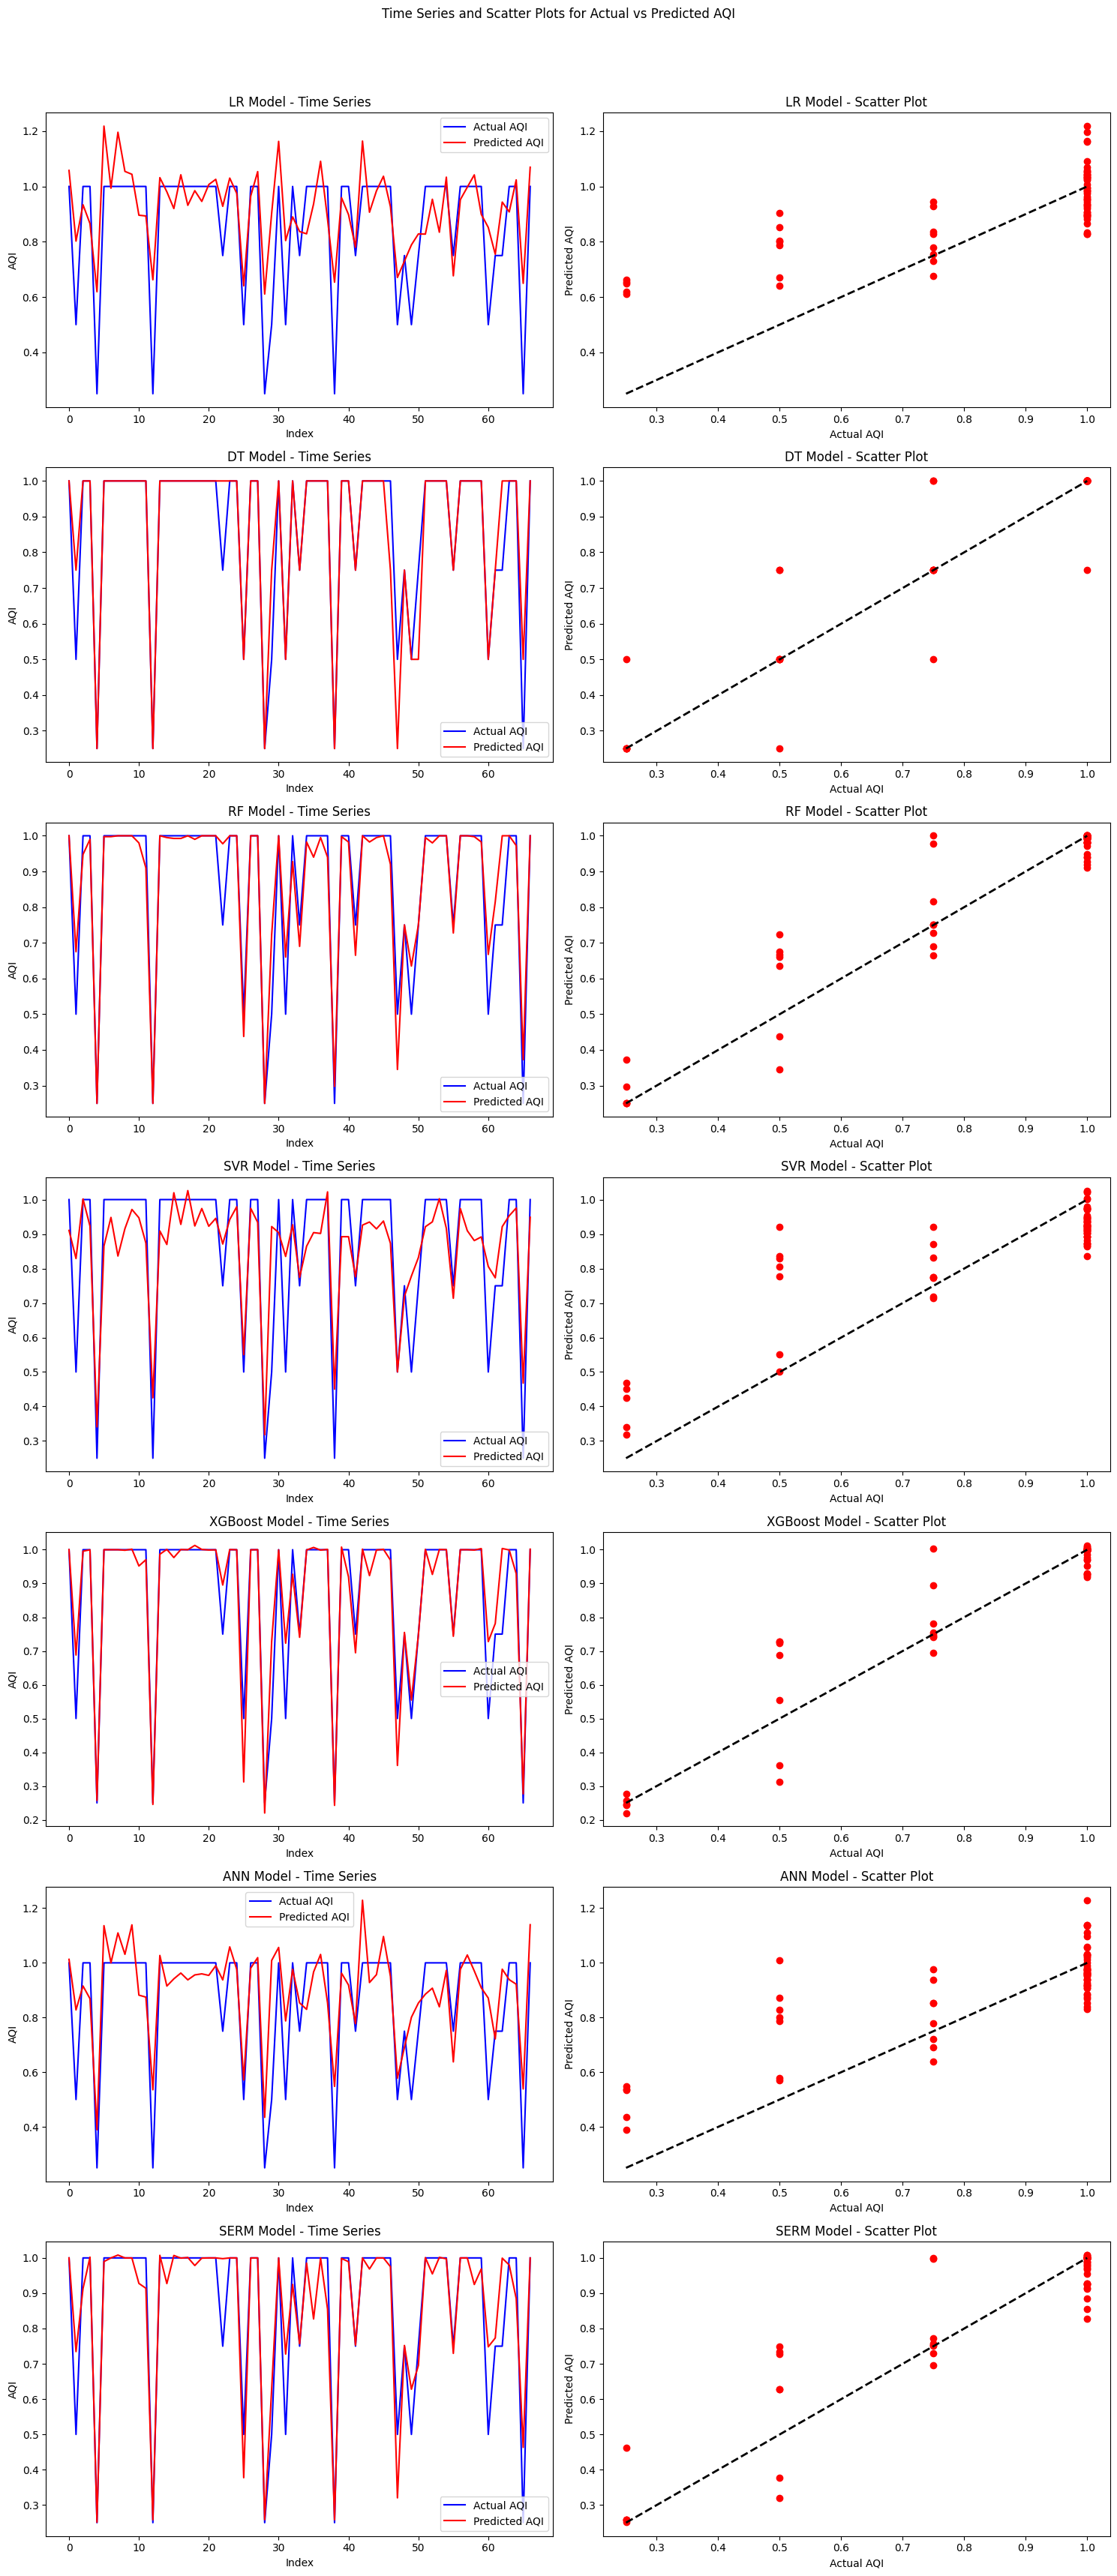

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv('aqi_dataset.csv')

# Drop non-numeric columns and extract features and target
df = df.drop(columns=['city', 'date', 'year', 'month', 'day'], errors='ignore')
X = df.drop(['aqi'], axis=1)
y = df['aqi']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split for all models including SERM
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define traditional models
models = {
    'LR': LinearRegression(),
    'DT': DecisionTreeRegressor(),
    'RF': RandomForestRegressor(),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(),
    'ANN': MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=1000, random_state=42)
}

# Initialize plots
fig, axes = plt.subplots(len(models) + 1, 2, figsize=(15, (len(models) + 1) * 5))
fig.suptitle('Time Series and Scatter Plots for Actual vs Predicted AQI')

# Train and plot traditional models
for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)

    # Time Series Plot
    axes[i, 0].plot(range(len(y_test)), y_test.values, label='Actual AQI', color='blue')
    axes[i, 0].plot(range(len(y_pred_test)), y_pred_test, label='Predicted AQI', color='red')
    axes[i, 0].set_title(f'{name} Model - Time Series')
    axes[i, 0].set_xlabel('Index')
    axes[i, 0].set_ylabel('AQI')
    axes[i, 0].legend()

    # Scatter Plot
    axes[i, 1].scatter(y_test, y_pred_test, color='red')
    axes[i, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axes[i, 1].set_title(f'{name} Model - Scatter Plot')
    axes[i, 1].set_xlabel('Actual AQI')
    axes[i, 1].set_ylabel('Predicted AQI')

# SERM: Stacked Ensemble Regression Model
base_learners = [
    ('lr', models['LR']),
    ('dt', models['DT']),
    ('rf', models['RF']),
    ('svr', models['SVR']),
    ('xgb', models['XGBoost'])
]
meta_learner = GradientBoostingRegressor(n_estimators=300, learning_rate=0.03, max_depth=5, random_state=42)
serm_model = StackingRegressor(estimators=base_learners, final_estimator=meta_learner, cv=10, n_jobs=-1)

# Fit and predict with SERM
serm_model.fit(X_train, y_train)
y_pred_serm = serm_model.predict(X_test)

# Plot SERM
i = len(models)
axes[i, 0].plot(range(len(y_test)), y_test.values, label='Actual AQI', color='blue')
axes[i, 0].plot(range(len(y_pred_serm)), y_pred_serm, label='Predicted AQI', color='red')
axes[i, 0].set_title('SERM Model - Time Series')
axes[i, 0].set_xlabel('Index')
axes[i, 0].set_ylabel('AQI')
axes[i, 0].legend()

axes[i, 1].scatter(y_test, y_pred_serm, color='red')
axes[i, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[i, 1].set_title('SERM Model - Scatter Plot')
axes[i, 1].set_xlabel('Actual AQI')
axes[i, 1].set_ylabel('Predicted AQI')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Training Linear Regression...
Explaining Linear Regression with SHAP...


  0%|          | 0/67 [00:00<?, ?it/s]

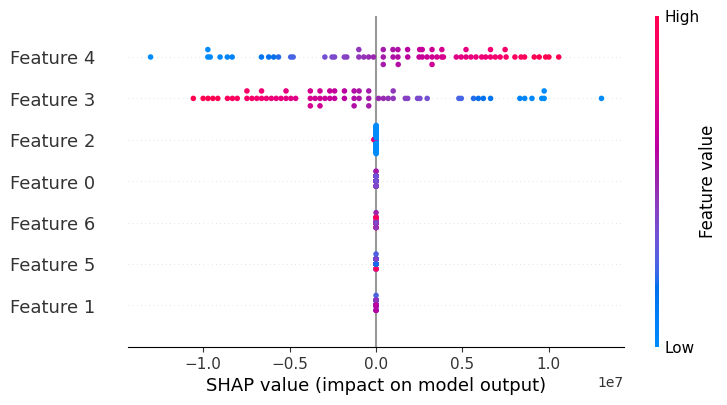

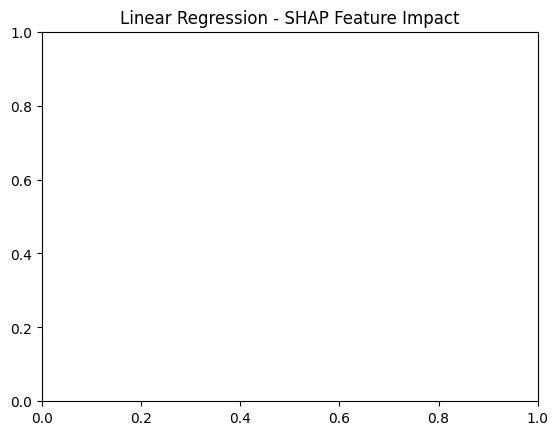

Training Decision Tree...
Explaining Decision Tree with SHAP...


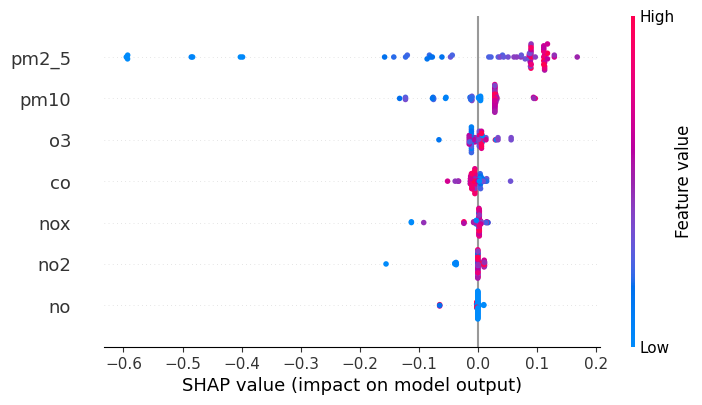

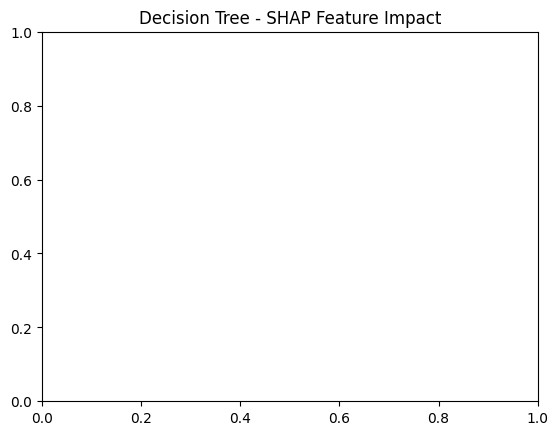

Training Random Forest...
Explaining Random Forest with SHAP...


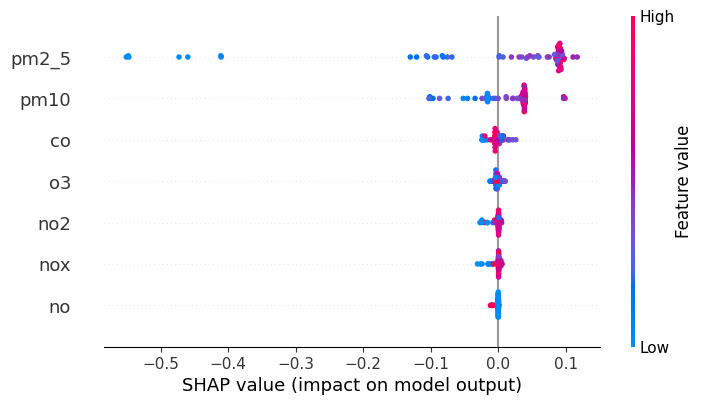

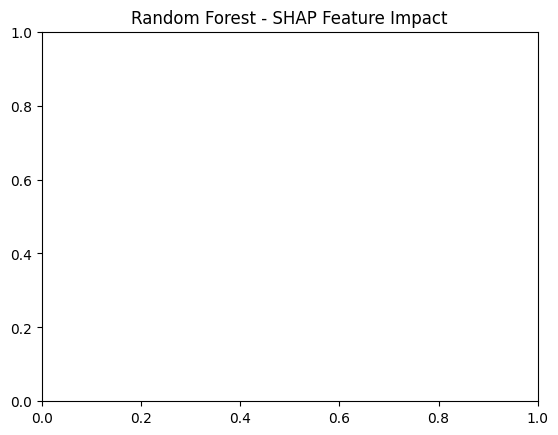

Training Support Vector Regressor...
Explaining Support Vector Regressor with SHAP...


  0%|          | 0/67 [00:00<?, ?it/s]

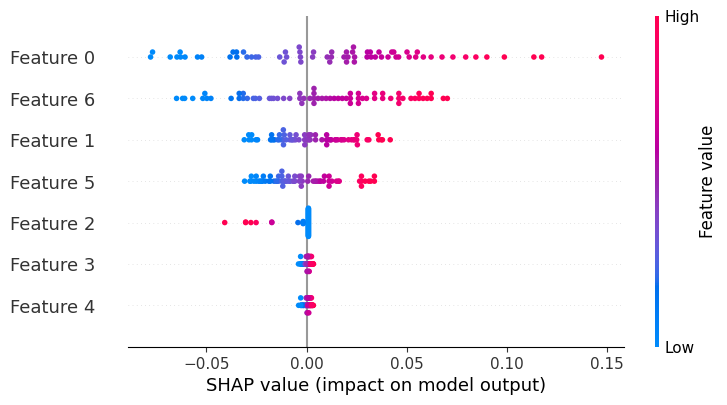

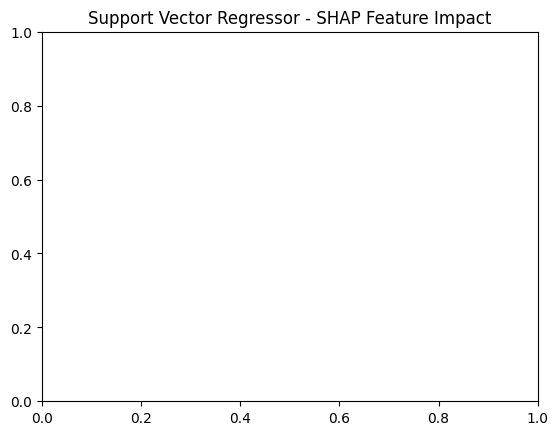

Training XGBoost...
Explaining XGBoost with SHAP...


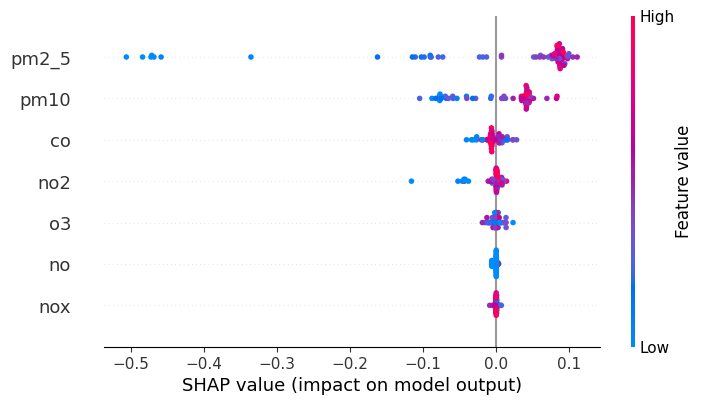

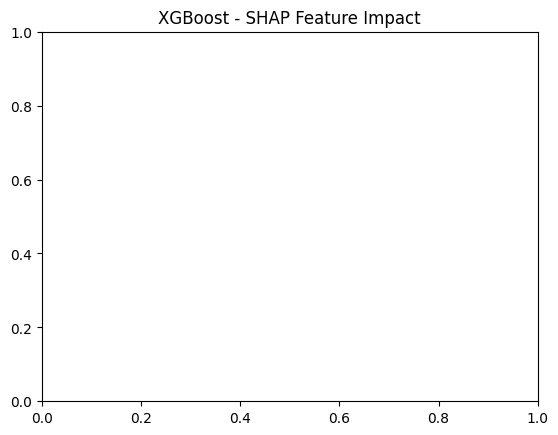

Training ANN...
Explaining ANN with SHAP...


  0%|          | 0/67 [00:00<?, ?it/s]

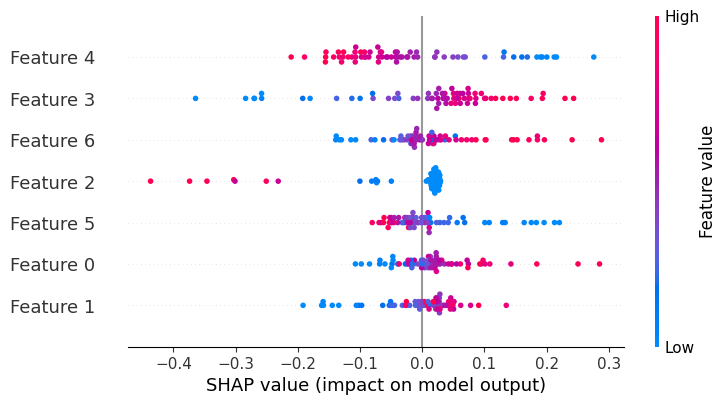

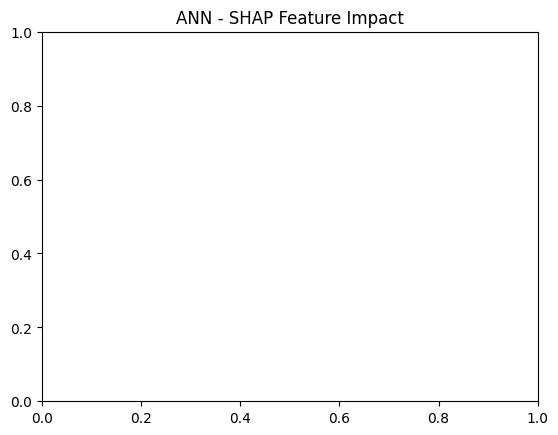

Training SERM (Stacked Ensemble)...
Explaining SERM (Stacked Ensemble) with SHAP...


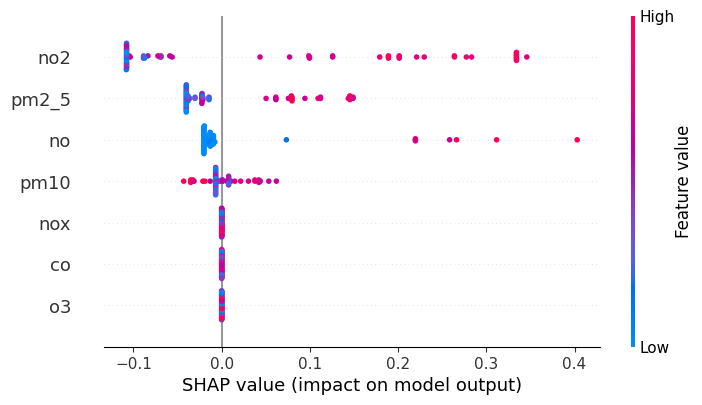

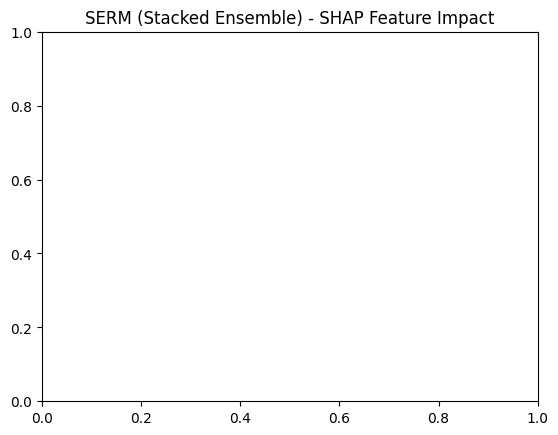

In [ ]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# Load the AQI dataset
df = pd.read_csv("aqi_dataset.csv")

# Drop irrelevant columns if they exist
df = df.drop(columns=['city', 'date', 'year', 'month', 'day'], errors='ignore')

# Split features and target
X = df.drop(columns=['aqi'])
y = df['aqi']
feature_names = X.columns.tolist()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Base models for SERM
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(max_depth=30, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42))
]

# Meta-model for SERM
meta_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)

# Define all models including SERM
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(kernel='linear'),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42),
    "ANN": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42),
    "SERM (Stacked Ensemble)": StackingRegressor(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1
    )
}

# SHAP analysis
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

    print(f"Explaining {name} with SHAP...")
    try:
        if name == "SERM (Stacked Ensemble)":
            # Use SHAP on the final estimator only
            explainer = shap.Explainer(model.final_estimator_, X_train, feature_names=feature_names)
        elif name in ['Random Forest', 'Decision Tree', 'XGBoost']:
            explainer = shap.Explainer(model, X_train, feature_names=feature_names)
        else:
            background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
            explainer = shap.KernelExplainer(model.predict, background)

        shap_values = explainer(X_test[:100])

        # Plot SHAP values
        shap.plots.beeswarm(shap_values, max_display=10)
        plt.title(f"{name} - SHAP Feature Impact")
        plt.show()

    except Exception as e:
        print(f"⚠️ SHAP failed for {name}: {e}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


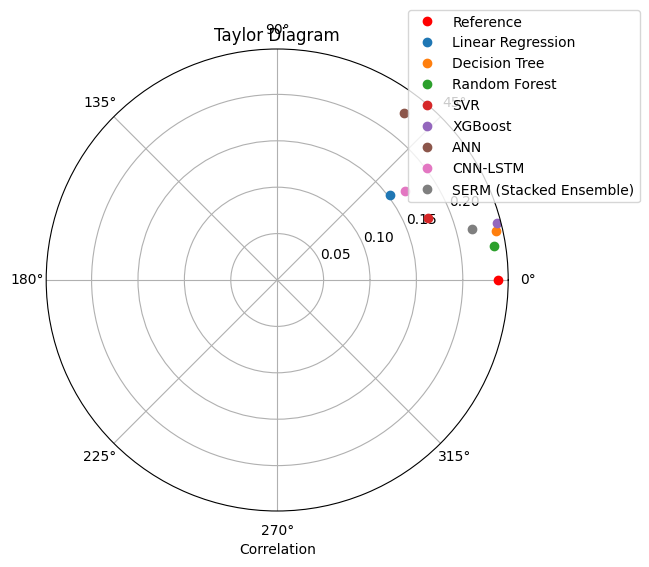

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, Reshape
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('aqi_dataset.csv')

# Encode categorical columns
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Drop missing values
df.dropna(inplace=True)

# Features and target
X = df.drop('aqi', axis=1)
y = df['aqi']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# For CNN and CNN-LSTM
X_cnn = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y, test_size=0.2, random_state=42)

# Store performance
models = {}

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
models['Linear Regression'] = (y_test, lr.predict(X_test))

# Decision Tree
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
models['Decision Tree'] = (y_test, dt.predict(X_test))

# Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
models['Random Forest'] = (y_test, rf.predict(X_test))

# SVR
svr = SVR()
svr.fit(X_train, y_train)
models['SVR'] = (y_test, svr.predict(X_test))

# XGBoost
xg = xgb.XGBRegressor()
xg.fit(X_train, y_train)
models['XGBoost'] = (y_test, xg.predict(X_test))

# ANN
ann = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
ann.compile(optimizer='adam', loss='mse')
ann.fit(X_train, y_train, epochs=20, verbose=0)
models['ANN'] = (y_test, ann.predict(X_test).flatten())

# CNN-LSTM
cnn_lstm = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Reshape((1, -1)),
    LSTM(64, activation='relu'),
    Dense(1)
])
cnn_lstm.compile(optimizer='adam', loss='mse')
cnn_lstm.fit(X_train_cnn, y_train_cnn, epochs=20, verbose=0)
models['CNN-LSTM'] = (y_test_cnn, cnn_lstm.predict(X_test_cnn).flatten())

# SERM (Stacked Ensemble Regression Model)
base_learners = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(max_depth=30, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42)),
    ('xgb', xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42))
]
meta_learner = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
stacking_model = StackingRegressor(estimators=base_learners, final_estimator=meta_learner, n_jobs=-1, cv=5)
stacking_model.fit(X_train, y_train)
models['SERM (Stacked Ensemble)'] = (y_test, stacking_model.predict(X_test))

# Taylor Diagram
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, polar=True)
ref_std = np.std(y_test)
ax.plot([0], [ref_std], 'ro', label='Reference')

for name, (y_true, y_pred) in models.items():
    std = np.std(y_pred)
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    theta = np.arccos(corr)
    ax.plot(theta, std, 'o', label=name)

ax.set_title("Taylor Diagram")
ax.set_xlabel("Correlation")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Model Performance (10-Fold CV):
Linear Regression: Avg RMSE = 0.1324, Avg R² = 0.4980
Decision Tree: Avg RMSE = 0.0297, Avg R² = 0.9633
Random Forest: Avg RMSE = 0.0275, Avg R² = 0.9750
SVR: Avg RMSE = 0.0938, Avg R² = 0.7389
XGBoost: Avg RMSE = 0.0341, Avg R² = 0.9610
ANN: Avg RMSE = 0.1755, Avg R² = 0.0331
SERM (Stacked Ensemble): Avg RMSE = 0.0665, Avg R² = 0.8604


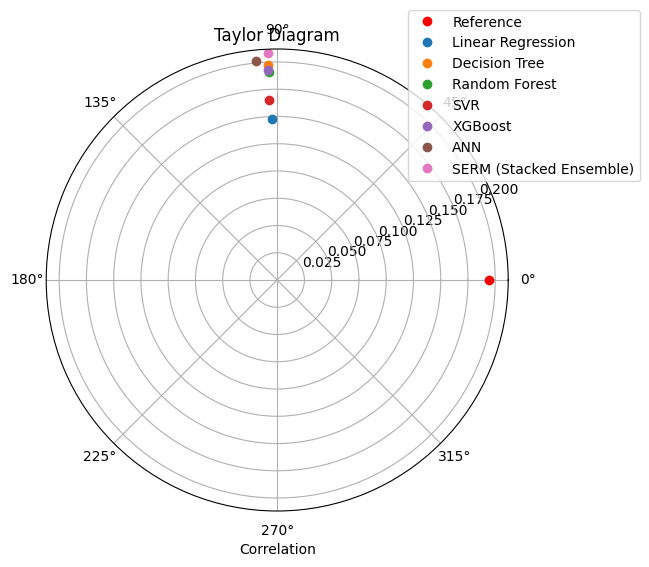

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('aqi_dataset.csv')

# Encode all categorical columns
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Drop rows with missing values
df.dropna(inplace=True)

# Features and target
X = df.drop('aqi', axis=1).values
y = df['aqi'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Store performance
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'SVR': SVR(),
    'XGBoost': xgb.XGBRegressor()
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

results = {}
y_preds_all = {}

for name, model in models.items():
    rmse_scores = []
    r2_scores = []
    y_pred_total = []
    for train_idx, test_idx in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_total.extend(y_pred)
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_scores.append(r2_score(y_test, y_pred))
    results[name] = (np.mean(rmse_scores), np.mean(r2_scores))
    y_preds_all[name] = np.array(y_pred_total)

# ANN model
def create_ann():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_scaled.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# ANN Evaluation
rmse_ann, r2_ann = [], []
y_pred_ann_all = []
for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    ann = create_ann()
    ann.fit(X_train, y_train, epochs=20, verbose=0)
    y_pred = ann.predict(X_test).flatten()
    y_pred_ann_all.extend(y_pred)
    rmse_ann.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_ann.append(r2_score(y_test, y_pred))
results['ANN'] = (np.mean(rmse_ann), np.mean(r2_ann))
y_preds_all['ANN'] = np.array(y_pred_ann_all)

# SERM Evaluation
base_learners = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(max_depth=30, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42)),
    ('xgb', xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42))
]
meta_learner = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)

rmse_serm, r2_serm = [], []
y_pred_serm_all = []

for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    serm = StackingRegressor(estimators=base_learners, final_estimator=meta_learner, n_jobs=-1, cv=5)
    serm.fit(X_train, y_train)
    y_pred = serm.predict(X_test)

    y_pred_serm_all.extend(y_pred)
    rmse_serm.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_serm.append(r2_score(y_test, y_pred))

results['SERM (Stacked Ensemble)'] = (np.mean(rmse_serm), np.mean(r2_serm))
y_preds_all['SERM (Stacked Ensemble)'] = np.array(y_pred_serm_all)

# Print performance
print("\nModel Performance (10-Fold CV):")
for name, (rmse, r2) in results.items():
    print(f"{name}: Avg RMSE = {rmse:.4f}, Avg R² = {r2:.4f}")

# Taylor Diagram
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, polar=True)
ref_std = np.std(y)
ax.plot([0], [ref_std], 'ro', label='Reference')

for name, y_pred in y_preds_all.items():
    std = np.std(y_pred)
    corr = np.corrcoef(y, y_pred)[0, 1]
    theta = np.arccos(corr)
    ax.plot(theta, std, 'o', label=name)

ax.set_title("Taylor Diagram")
ax.set_xlabel("Correlation")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


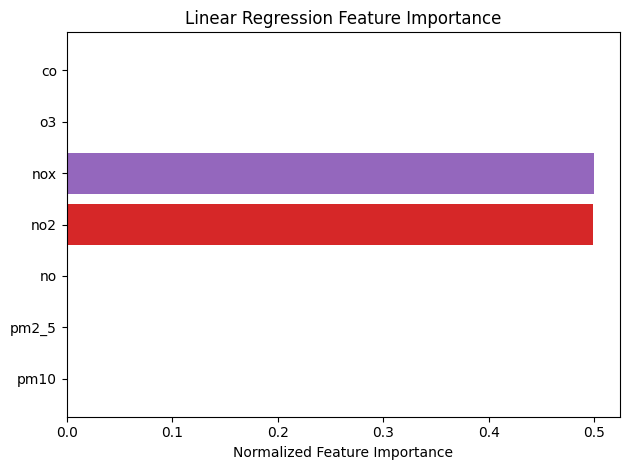

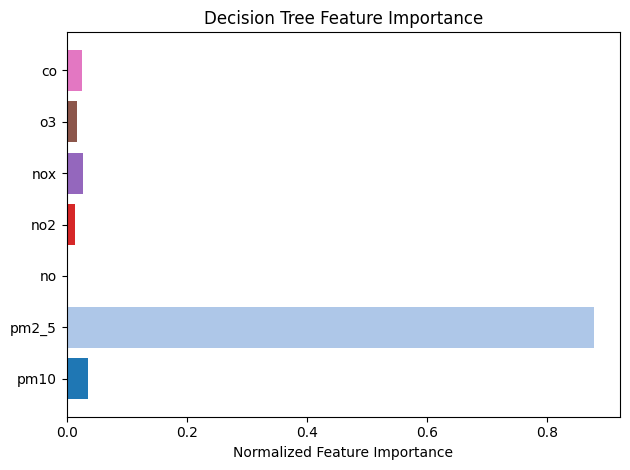

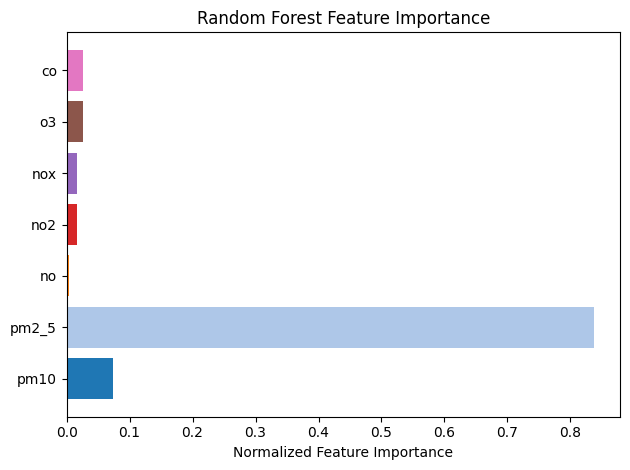

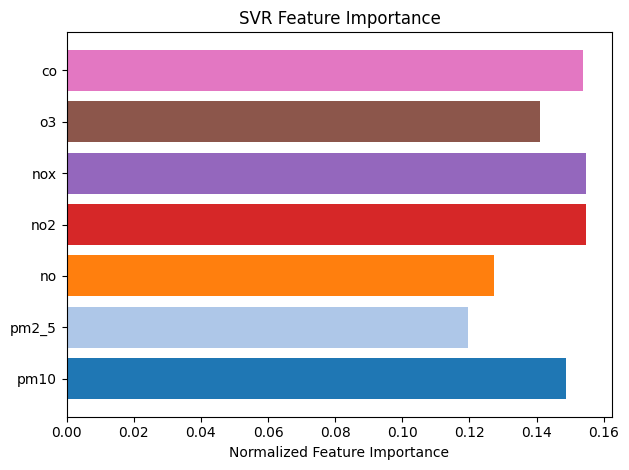

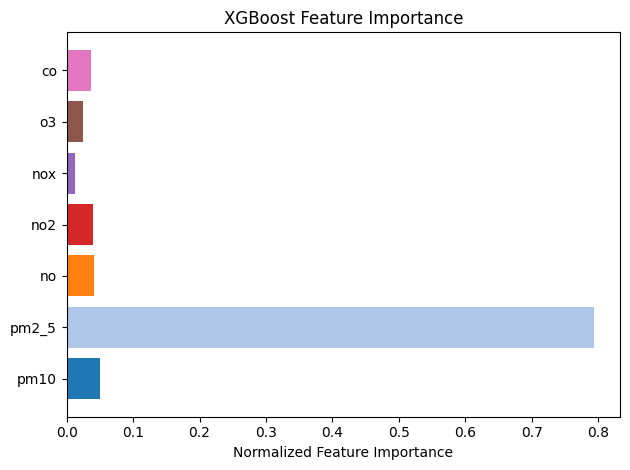

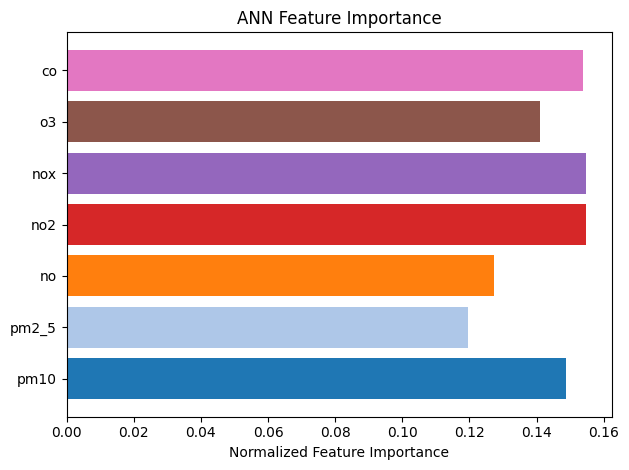


SERM (Stacked Ensemble) Evaluation:
MSE: 0.0061
RMSE: 0.0783
R² Score: 0.8916


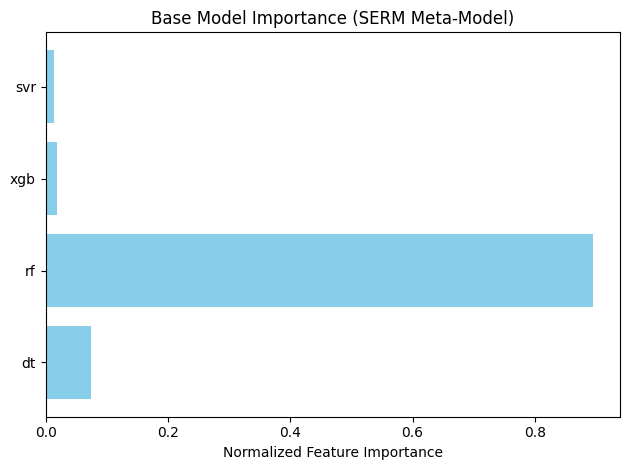

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load and preprocess dataset
df = pd.read_csv('aqi_dataset.csv')
df = df.drop(columns=['city', 'date', 'year', 'month', 'day'], errors='ignore')

# Define pollutant features and colors
pollutants = ['pm10', 'pm2_5', 'no', 'no2', 'nox', 'o3', 'co']
colors = ['#1f77b4', '#aec7e8', '#ff7f0e', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Features and target
X = df[pollutants]
y = df['aqi']

# Scale target
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

# Standardize features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Classic models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf', C=1, epsilon=0.1),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    'ANN': MLPRegressor(hidden_layer_sizes=(256, 128), activation='relu', solver='adam',
                        max_iter=1000, random_state=42, early_stopping=True, validation_fraction=0.1)
}

# Plot function
def plot_importance(labels, importances, title, color_scheme):
    normalized = importances / np.sum(importances)
    plt.barh(labels, normalized, color=color_scheme)
    plt.xlabel('Normalized Feature Importance')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Train classic models and plot
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    if hasattr(model, 'coef_'):
        importance = np.abs(model.coef_)
    elif hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        importance = np.mean(np.abs(X_test_scaled), axis=0)  # fallback
    plot_importance(pollutants, importance, f'{model_name} Feature Importance', colors)

# ---------------- SERM ------------------
# Define base learners for SERM
base_models = {
    'dt': DecisionTreeRegressor(random_state=42),
    'rf': RandomForestRegressor(n_estimators=100, random_state=42),
    'xgb': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    'svr': SVR(kernel='rbf', C=1, epsilon=0.1)
}

# Final estimator
meta_model = LinearRegression()

# Stack ensemble model
serm = StackingRegressor(estimators=list(base_models.items()), final_estimator=meta_model)
serm.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_serm = serm.predict(X_test_scaled)
y_pred_serm_inv = scaler_y.inverse_transform(y_pred_serm.reshape(-1, 1)).ravel()
y_true_serm = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

mse = mean_squared_error(y_true_serm, y_pred_serm_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_serm, y_pred_serm_inv)

print("\nSERM (Stacked Ensemble) Evaluation:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot base model importance in SERM
if hasattr(serm.final_estimator_, 'coef_'):
    serm_importance = np.abs(serm.final_estimator_.coef_)
elif hasattr(serm.final_estimator_, 'feature_importances_'):
    serm_importance = serm.final_estimator_.feature_importances_
else:
    serm_importance = np.ones(len(base_models)) / len(base_models)

plot_importance(
    labels=list(base_models.keys()),
    importances=serm_importance,
    title='Base Model Importance (SERM Meta-Model)',
    color_scheme='skyblue'
)


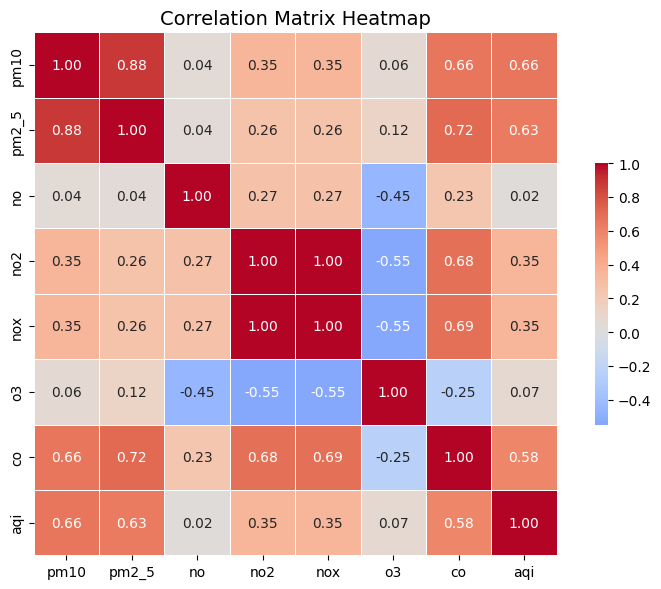

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("aqi_dataset.csv")

# Drop non-numeric or irrelevant columns
df = df.drop(columns=['city', 'date', 'year', 'month', 'day'], errors='ignore')

# Compute correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt='.2f',
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5}
)
plt.title("Correlation Matrix Heatmap", fontsize=14)
plt.tight_layout()
plt.show()
